In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid

BATCH_SIZE = 64
Z_VECTOR_SIZE = 100
IMG_SIZE = 28*28

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
dataset = datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize([0.5], [0.5]) # changes the pixel value range to [-1, 1] (suited for tanh)
                   ]))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(Z_VECTOR_SIZE, 128)

        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256, 0.8)

        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512, 0.8)

        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024, 0.8)

        self.fc5 = nn.Linear(1024, IMG_SIZE)
        self.tanh = nn.Tanh()
        self.leakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        out = self.leakyReLU(self.fc1(x))
        out = self.leakyReLU(self.bn2(self.fc2(out)))
        out = self.leakyReLU(self.bn3(self.fc3(out)))
        out = self.leakyReLU(self.bn4(self.fc4(out)))
        out = self.tanh(self.fc5(out))
        return out
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(IMG_SIZE, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.leakyReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.leakyReLU(self.fc1(x))
        out = self.leakyReLU(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out

In [4]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [5]:
def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

Epoch 0


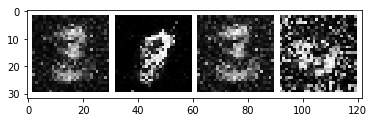

Epoch 5


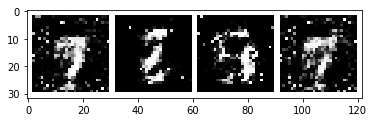

Epoch 10


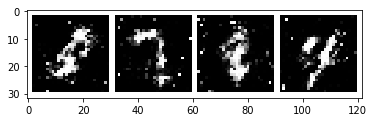

Epoch 15


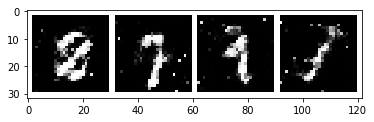

Epoch 20


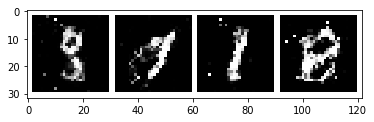

Epoch 25


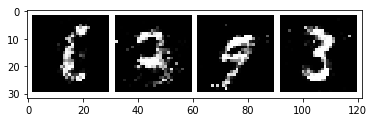

Epoch 30


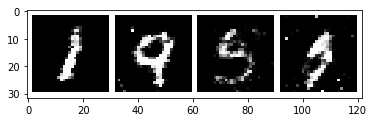

Epoch 35


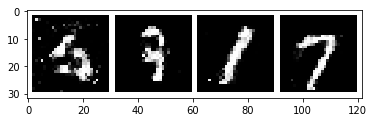

Epoch 40


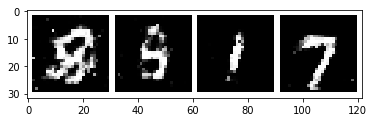

Epoch 45


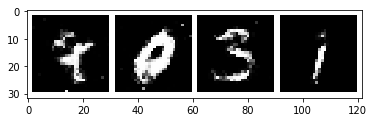

Epoch 50


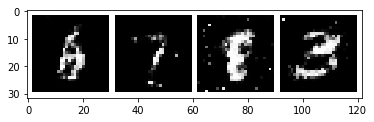

Epoch 55


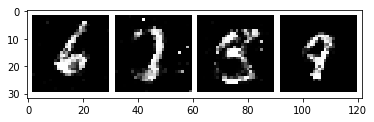

Epoch 60


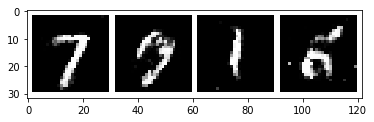

Epoch 65


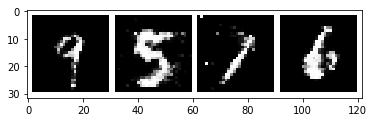

Epoch 70


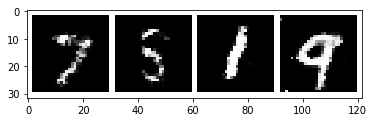

In [6]:
NB_EPOCH = 71

losses_discriminator_real = []
losses_discriminator_fake = []
losses_generator = []

real = torch.ones(BATCH_SIZE, 1).to(device)
fake = torch.zeros(BATCH_SIZE, 1).to(device)
    
for epoch in range(NB_EPOCH):
    for batch_id, (img, _) in enumerate(train_loader):
        # Train discriminator on real data
        optimizer_discriminator.zero_grad()
        real_img = img.view(img.shape[0], -1).to(device)
        target = real
        
        out = discriminator(real_img)
        loss_discriminator_real = criterion(out, target)
        losses_discriminator_real.append(loss_discriminator_real)

        # Train discriminator on fake data
        z_vector = torch.randn(BATCH_SIZE, Z_VECTOR_SIZE).to(device)
        fake_img = generator(z_vector)
        target = fake

        out = discriminator(fake_img)
        loss_discriminator_fake = criterion(out, target)
        losses_discriminator_fake.append(loss_discriminator_fake)

        loss_discriminator = loss_discriminator_real + loss_discriminator_fake
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Train generator
        optimizer_generator.zero_grad()
        z_vector = torch.randn(BATCH_SIZE, Z_VECTOR_SIZE).to(device)
        fake_img = generator(z_vector)
        target = real

        out = discriminator(fake_img)
        loss_generator = criterion(out, target)
        losses_generator.append(loss_generator)
        
        loss_generator.backward()
        optimizer_generator.step()
        
    # Show a few generated fake images
    if epoch % 5 == 0:
        print("Epoch", epoch)
        z_vector = torch.randn(4, Z_VECTOR_SIZE).to(device)
        fake_img = generator(z_vector)
        fake_img = fake_img.view(fake_img.shape[0], 1, 28, 28)
        show(make_grid(fake_img, normalize=True, pad_value=1))
        plt.show()

In [7]:
# Print the losses of the first 10 batches of each epoch
for i, (loss_d_real, loss_d_fake, loss_g) in enumerate(zip(losses_discriminator_real, 
                                                           losses_discriminator_fake, 
                                                           losses_generator)):
    if i%len(train_loader) < 10:
        print(f"D loss real: {loss_d_real:.2f} |",
              f"D loss fake: {loss_d_fake:.2f} |",
              f"G loss: {loss_g:.2f} | Epoch {i//len(train_loader)} | Batch {i%len(train_loader)+1}/{len(train_loader)}")

D loss real: 0.74 | D loss fake: 0.66 | G loss: 0.72 | Epoch 0 | Batch 1/937
D loss real: 0.57 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 2/937
D loss real: 0.44 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 3/937
D loss real: 0.33 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 4/937
D loss real: 0.25 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 5/937
D loss real: 0.17 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 6/937
D loss real: 0.12 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 7/937
D loss real: 0.08 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 8/937
D loss real: 0.06 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 9/937
D loss real: 0.04 | D loss fake: 0.67 | G loss: 0.72 | Epoch 0 | Batch 10/937
D loss real: 0.19 | D loss fake: 0.38 | G loss: 2.57 | Epoch 1 | Batch 1/937
D loss real: 0.57 | D loss fake: 0.18 | G loss: 1.00 | Epoch 1 | Batch 2/937
D loss real: 0.08 | D loss fake: 0.96 | G loss: 3.55 | Epoch 1 | Batch 3/93